In [2]:
include("./tools.jl")
using Plots
using Distributed

$$\hat{H} = t\sum_{i,j}c^\dagger_{i\sigma}c_{j\sigma} + U\sum_{i\sigma}c^\dagger_{i\sigma}c_{i\sigma}c^\dagger_{i\bar{\sigma}}c_{i\bar{\sigma}}\\
 \hat{H}' =  \hat{H} + M\sum_{i\sigma}e^{iQr_i}(-1)^{\sigma}c^\dagger_{i\sigma}c_{i\sigma} \quad Q=[\pi,\pi]$$

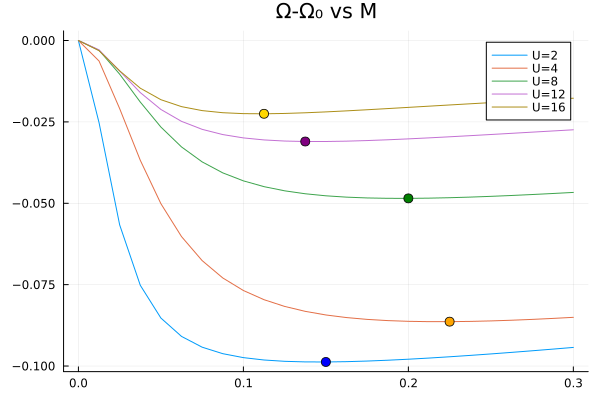

In [5]:
#=
spawn(3)
@everywhere begin
    include("./tools.jl")
    include("./exam_SqLAF.jl")
end 
gp = [pmap(a -> gps([u, a]), M) for u in [2,4,8,12,16]]
=#
f = plot(range(0, 0.3, 25), gp[1].-gp[1][1], label="U=2", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gp[2].-gp[2][1], label="U=4", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gp[3].-gp[3][1], label="U=8", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gp[4].-gp[4][1], label="U=12", legend=:topright, title="Ω-Ω₀ vs M")
plot!(range(0, 0.3, 25), gp[5].-gp[5][1], label="U=16", legend=:topright, title="Ω-Ω₀ vs M")
min_y, min_index = findmin((1)*(gp[1].-gp[1][1]))

scatter!([range(0, 0.3, 25)[min_index]], [min_y], mark=:circle, markersize=5, color=:blue, label=nothing)
min_y, min_index = findmin((gp[2].-gp[2][1]))
scatter!([range(0, 0.3, 25)[min_index]], [min_y], mark=:circle, markersize=5, color=:orange, label=nothing)
min_y, min_index = findmin((gp[3].-gp[3][1]))
scatter!([range(0, 0.3, 25)[min_index]], [min_y], mark=:circle, markersize=5, color=:green, label=nothing)
min_y, min_index = findmin((gp[4].-gp[4][1]))
scatter!([range(0, 0.3, 25)[min_index]], [min_y], mark=:circle, markersize=5, color=:purple, label=nothing)
min_y, min_index = findmin((gp[5].-gp[5][1]))
scatter!([range(0, 0.3, 25)[min_index]], [min_y], mark=:circle, markersize=5, color=:gold, label=nothing)

$$\hat{H} = t\sum_{i,j}c^\dagger_{i\sigma}c_{j\sigma} + U\sum_{i\sigma}c^\dagger_{i\sigma}c_{i\sigma}c^\dagger_{i\bar{\sigma}}c_{i\bar{\sigma}} + \mu\sum_{i}c^\dagger_{i\sigma}c_{i\sigma}\\
 \hat{H}' =  \hat{H} + \hat{\Delta}$$

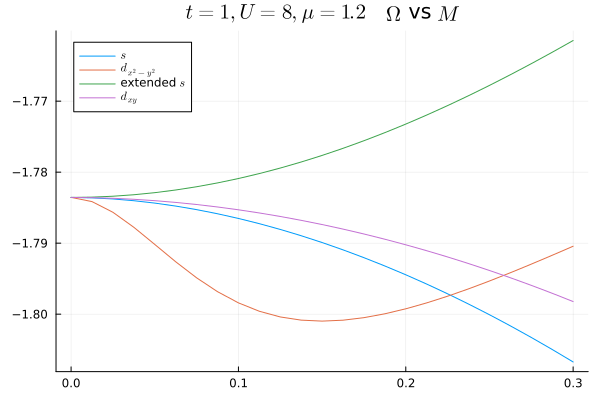

In [13]:
spawn(3)
@everywhere begin
    include("./tools.jl")
    include("./exam_SqLSC.jl")
end 
gp = [pmap(a -> gps1([a]), M), pmap(a -> gps2([a]), M), pmap(a -> gps3([a]), M), pmap(a -> gps4([a]), M)]
using LaTeXStrings
f = plot(range(0, 0.3, 25), gp[1], label=LaTeXStrings.L"$s$", title=LaTeXStrings.L"$t=1,U=8,\mu=1.2$   $Ω$ vs $M$")
plot!(range(0, 0.3, 25), gp[2], label=LaTeXStrings.L"$d_{x^2-y^2}$")
plot!(range(0, 0.3, 25), gp[3], label=LaTeXStrings.L"extended $s$")
plot!(range(0, 0.3, 25), gp[4], label=LaTeXStrings.L"$d_{xy}$")


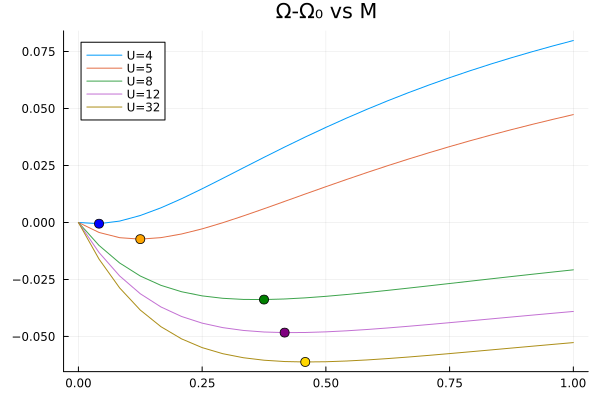

In [14]:
spawn(3)
@everywhere begin
    include("./tools.jl")
    include("./exam_TriLSO.jl")
end 
nes = [pmap(m -> Newton(x -> gps1([m, x...]), [-2.0]), M1), pmap(m -> Newton(x -> gps2([m, x...]), [-2.5]), M2), pmap(m -> Newton(x -> gps3([m, x...]), [-4.0]), M3), pmap(m -> Newton(x -> gps4([m, x...]), [-6.0]), M4), pmap(m -> Newton(x -> gps5([m, x...]), [-16.0]), M5)]
gp = [pmap(i -> gps1([Vector(M1)[i], [x[1] for x in nes[1]][i]...]), 1:25), pmap(i -> gps2([Vector(M2)[i], [x[1] for x in nes[2]][i]...]), 1:25), pmap(i -> gps3([Vector(M3)[i], [x[1] for x in nes[3]][i]...]), 1:25), pmap(i -> gps4([Vector(M4)[i], [x[1] for x in nes[4]][i]...]), 1:25), pmap(i -> gps5([Vector(M5)[i], [x[1] for x in nes[5]][i]...]), 1:25)]

f = plot(range(0, 1, 25), (1)*(gp[1].-gp[1][1]), label="U=4",xlabel="M" title="(Ω-Ω₀)/J vs M/J  J=4t²/U")
plot!(range(0, 1, 25),  (5/4)*(gp[2].-gp[2][1]), label="U=5", title="Ω-Ω₀ vs M")
plot!(range(0, 1, 25),  (2)*(gp[3].-gp[3][1]), label="U=8", title="Ω-Ω₀ vs M")
plot!(range(0, 1, 25), (3)*(gp[4].-gp[4][1]), label="U=12", title="Ω-Ω₀ vs M")
plot!(range(0, 1, 25), (8)*(gp[5].-gp[5][1]), label="U=32", title="Ω-Ω₀ vs M")
min_y, min_index = findmin((1)*(gp[1].-gp[1][1]))
scatter!([range(0, 1, 25)[min_index]], [min_y], mark=:circle, markersize=5, color=:blue, label=nothing)
min_y, min_index = findmin((5/4)*(gp[2].-gp[2][1]))
scatter!([range(0, 1, 25)[min_index]], [min_y], mark=:circle, markersize=5, color=:orange, label=nothing)
min_y, min_index = findmin((2)*(gp[3].-gp[3][1]))
scatter!([range(0, 1, 25)[min_index]], [min_y], mark=:circle, markersize=5, color=:green, label=nothing)
min_y, min_index = findmin((3)*(gp[4].-gp[4][1]))
scatter!([range(0, 1, 25)[min_index]], [min_y], mark=:circle, markersize=5, color=:purple, label=nothing)
min_y, min_index = findmin((8)*(gp[5].-gp[5][1]))
scatter!([range(0, 1, 25)[min_index]], [min_y], mark=:circle, markersize=5, color=:gold, label=nothing)